# **Daily Climate Time Series Forecast**

In this notebook, we build a multivariate time series forecasting using RNN(LSTM).

about the data: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Workflow:
1. apply scaler to the data
2. prepare data into multivariate format and split into train and val set
3. RNN model building and training
4. evaluate on test data

# **Imports**

In [2]:
import os
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

# **Data Review**

In [3]:
#load data
TRAINING_DIR = "DailyDelhiClimateTrain.csv"

training_data = pd.read_csv(TRAINING_DIR)

In [4]:
print(f"training data has the shape of {training_data.shape}")
training_data.head()

training data has the shape of (1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
# check missing values in data
print("training data:")
for i in training_data.columns:
    print("Missing Values in ", i , "is -",training_data[i].isna().sum())


training data:
Missing Values in  date is - 0
Missing Values in  meantemp is - 0
Missing Values in  humidity is - 0
Missing Values in  wind_speed is - 0
Missing Values in  meanpressure is - 0


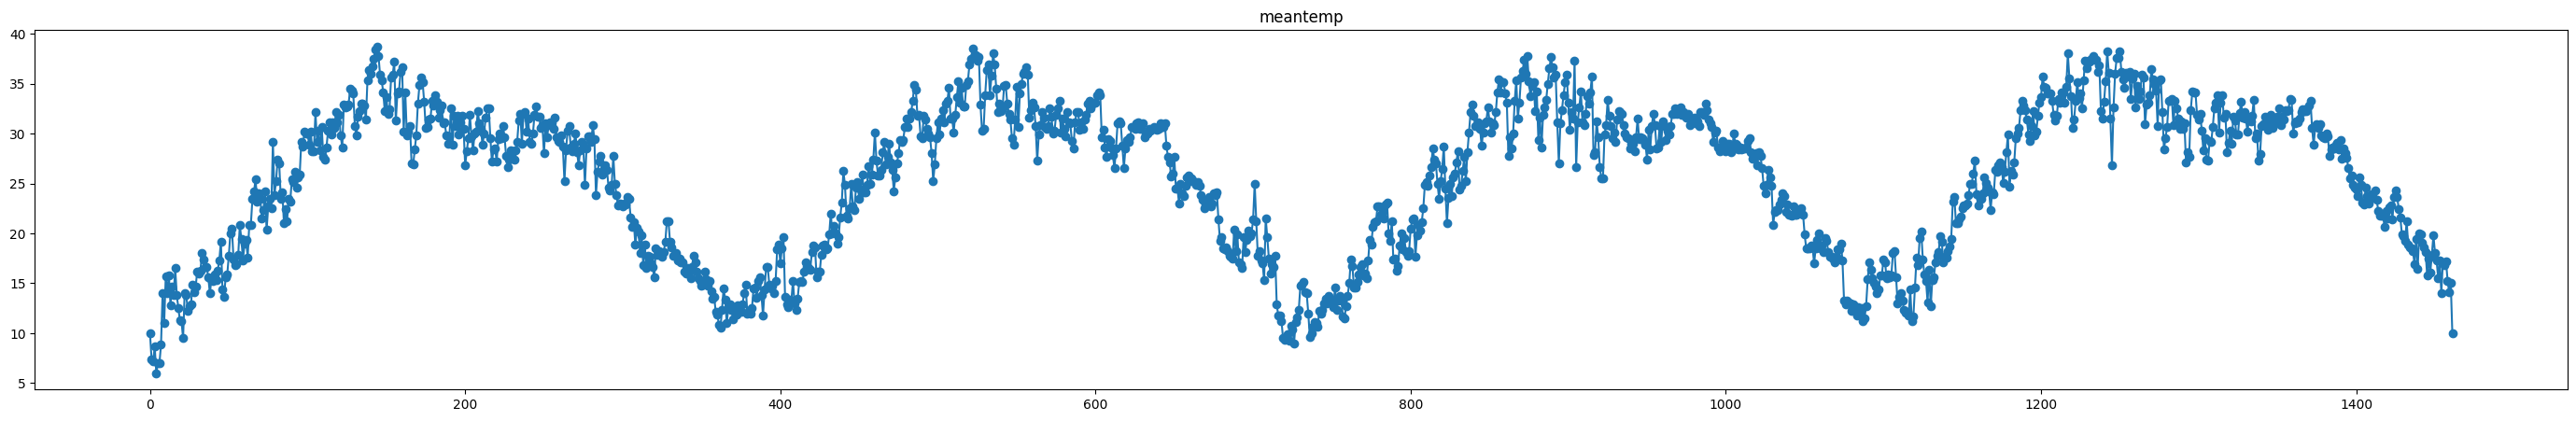

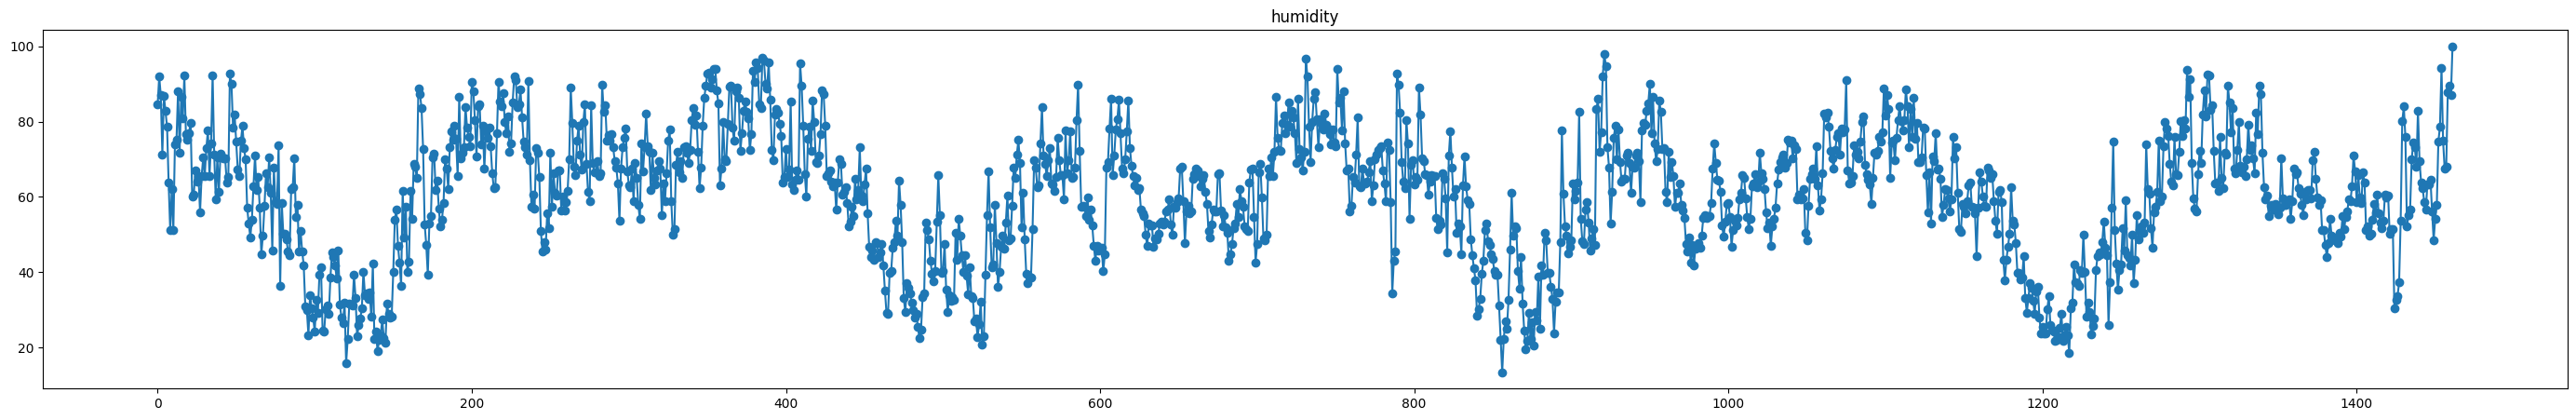

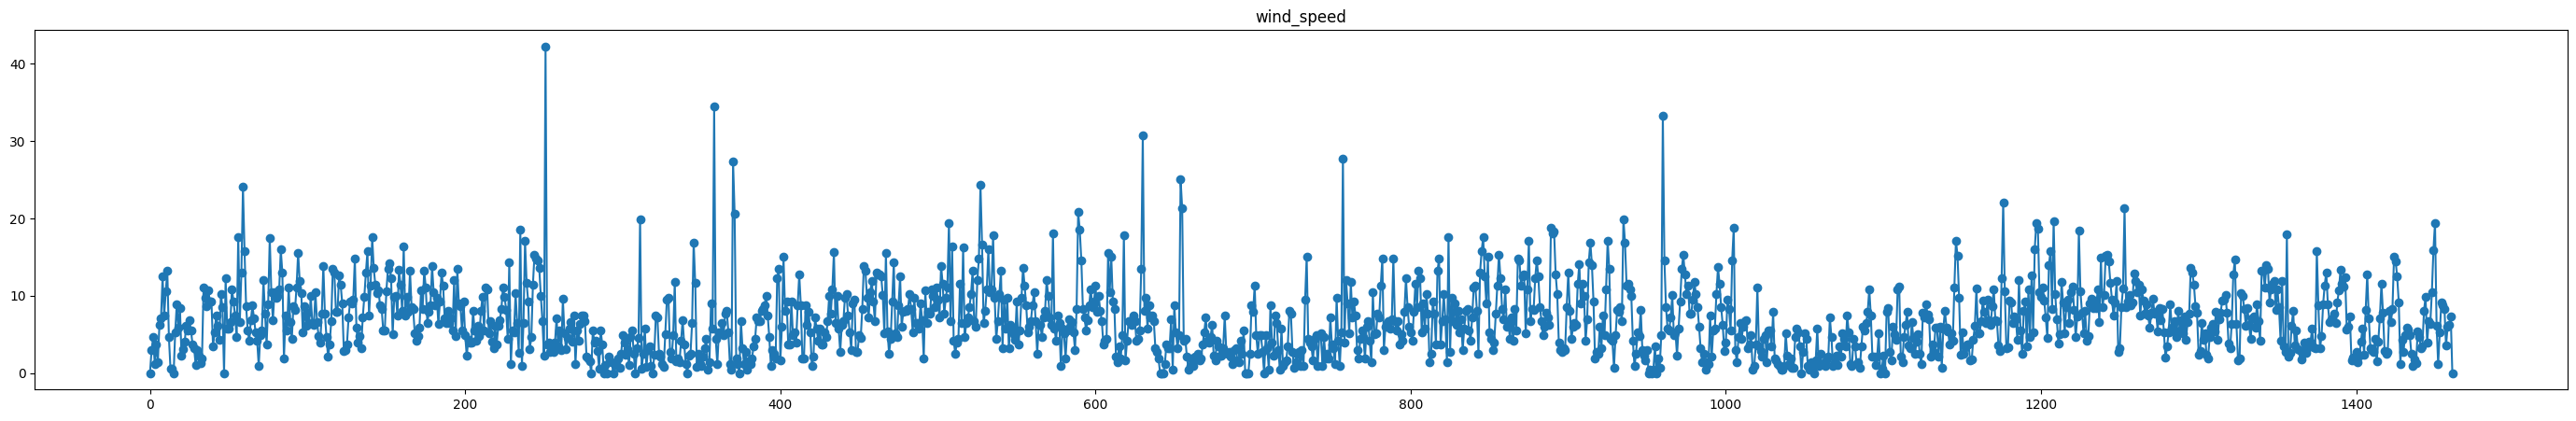

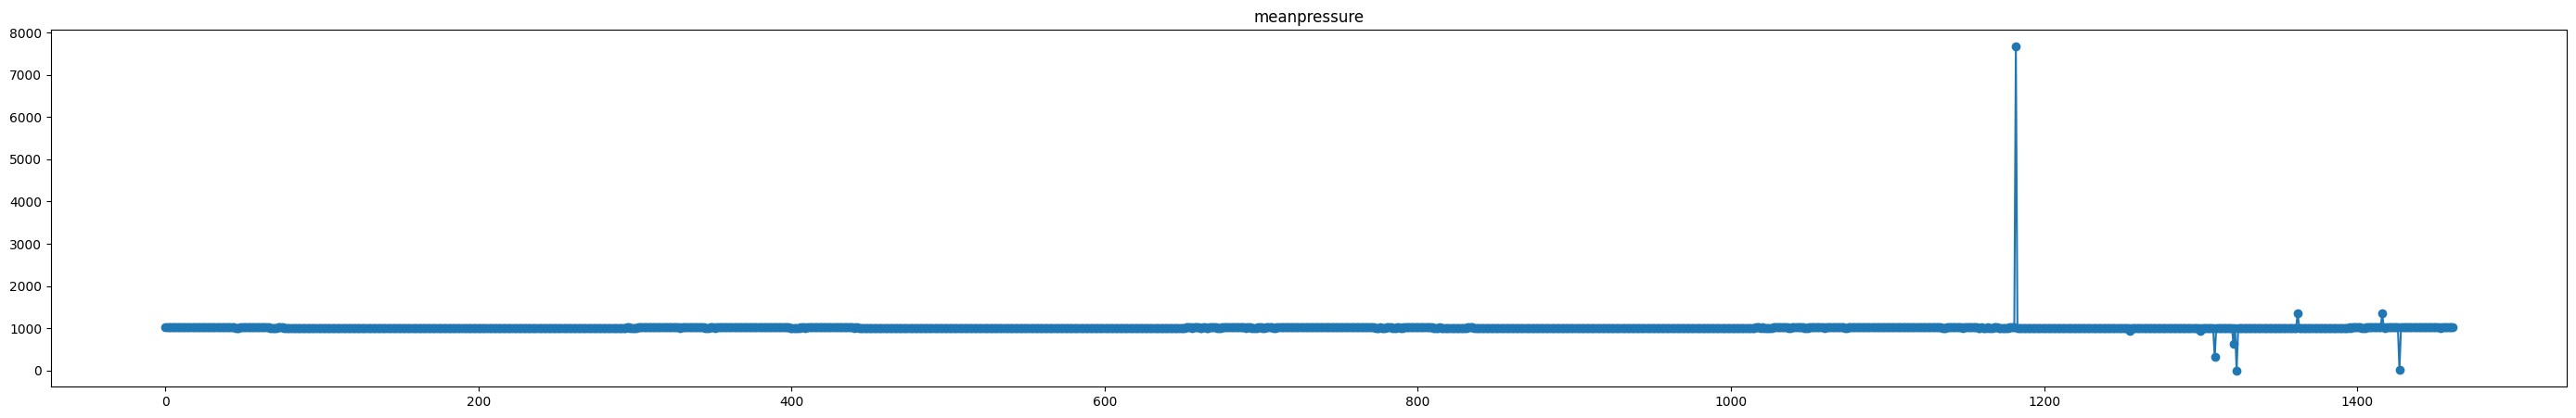

In [6]:
# data visualization
for i in training_data.drop(columns='date').columns:
    plt.figure(figsize=(35,5))
    plt.plot(training_data[i], label=i, marker='o')
    plt.title(i)
    plt.show()

# **Data Processing**

In [7]:
# use scaler to scale down the values
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(training_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure',]])
Y_data = Y_scaler.fit_transform(training_data[['meantemp']]) 

print(X_data.shape, Y_data.shape)

(1462, 4) (1462, 1)


In [8]:

def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    """
    dataset: the dataset used for training
    target: the target for the dataset
    start: starting datapoint in the dataset
    end: ending datapoint in the dataset
    window: datapoints used to generate a forecast
    horizon: datapoints generated in a forecast
    """
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y) 

In [9]:
# use 48 days of  weather data to forecast the meantemperature in the next day
hist_window = 48 
horizon = 1
# 80/20 train/validation split  
TRAIN_SPLIT = 1200

x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

print(f"training data have shape: {x_train.shape}; training target have shape: {y_train.shape}")
print(f"training data have shape: {x_vali.shape}; training target have shape: {y_vali.shape}")

training data have shape: (1152, 48, 4); training target have shape: (1152, 1, 1)
training data have shape: (213, 48, 4); training target have shape: (213, 1, 1)


In [10]:
# view first training set
print ('48 days of past history data(meantemp, humidity, wind_speed, meanpressure)\n')
print(x_train[0])
print ('\n meantemp of the next day \n')
print (y_train[0])

48 days of past history data(meantemp, humidity, wind_speed, meanpressure)

[[0.12227074 0.8209571  0.         0.13260331]
 [0.04279476 0.90759076 0.07058266 0.132881  ]
 [0.0356623  0.84983498 0.10974262 0.13299381]
 [0.08151383 0.66886689 0.02921206 0.13279856]
 [0.         0.84790979 0.08763619 0.13271178]
 [0.03056769 0.80132013 0.03505448 0.13290703]
 [0.03056769 0.75280528 0.14921838 0.13316737]
 [0.08733624 0.58085809 0.16918184 0.13300001]
 [0.24454148 0.43688119 0.29606821 0.13277686]
 [0.15283843 0.56105611 0.17527238 0.13260331]
 [0.29694323 0.43729373 0.25038912 0.13266529]
 [0.24454148 0.69966997 0.31332476 0.13259091]
 [0.30058224 0.71314631 0.10974262 0.13229958]
 [0.20887918 0.86331133 0.01460603 0.13253822]
 [0.26637555 0.67491749 0.01251946 0.1326281 ]
 [0.23944687 0.8459846  0.         0.13273348]
 [0.3209607  0.77860286 0.12434865 0.132625  ]
 [0.23944687 0.90951595 0.21198484 0.13245144]
 [0.19868996 0.73047305 0.13934944 0.13338432]
 [0.16157205 0.71452145 0.20064

In [11]:
# prepare the training and validation data into tensorflow dataset 
batch_size = 32
buffer_size = 16

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat() 

In [12]:
lstm_model = tf.keras.models.Sequential([
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])

lstm_model.compile(optimizer='adam', loss='mse')

In [13]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 128)          35328     
 l)                                                              
                                                                 
 dense (Dense)               (None, 48, 20)            2580      
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              43520     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0

In [14]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = lstm_model.fit(train_data,epochs=150,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/150
100/100 [==============================] - 21s 57ms/step - loss: 0.0480 - val_loss: 0.0082
Epoch 2/150
100/100 [==============================] - 4s 37ms/step - loss: 0.0138 - val_loss: 0.0087
Epoch 3/150
100/100 [==============================] - 4s 37ms/step - loss: 0.0154 - val_loss: 0.0254
Epoch 4/150
100/100 [==============================] - 4s 37ms/step - loss: 0.0140 - val_loss: 0.0057
Epoch 5/150
100/100 [==============================] - 4s 36ms/step - loss: 0.0105 - val_loss: 0.0045
Epoch 6/150
100/100 [==============================] - 4s 36ms/step - loss: 0.0113 - val_loss: 0.0176
Epoch 7/150
100/100 [==============================] - 4s 35ms/step - loss: 0.0157 - val_loss: 0.0049
Epoch 8/150
100/100 [==============================] - 4s 38ms/step - loss: 0.0101 - val_loss: 0.0056
Epoch 9/150
100/100 [==============================] - 4s 39ms/step - loss: 0.0099 - val_loss: 0.0043
Epoch 10/150
100/100 [==============================] - 4s 36ms/step - loss: 0.00

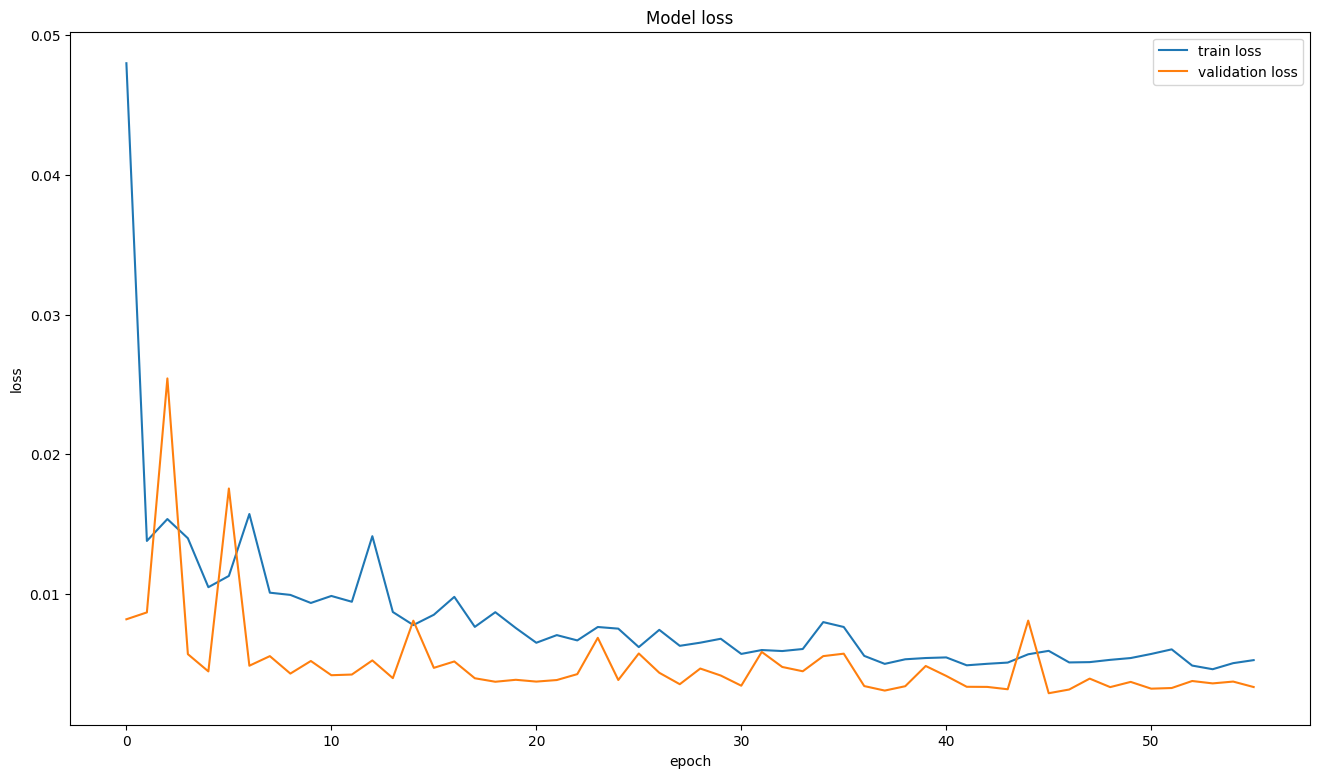

In [15]:
# plot training results
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

# **Evaluate on Test Data**

In [16]:
# load test data
TEST_DIR = "DailyDelhiClimateTest.csv"

test_data = pd.read_csv(TEST_DIR)

In [17]:
# apply scaler on test data
X_test_data = X_scaler.fit_transform(test_data[['meantemp', 'humidity', 'wind_speed', 'meanpressure',]])
Y_test_data = Y_scaler.fit_transform(test_data[['meantemp']]) 

# check the shape of test data
print(X_test_data.shape, Y_test_data.shape)

(114, 4) (114, 1)


In [18]:
# test data preperation
x_test, y_test = custom_ts_multi_data_prep(X_test_data, Y_test_data, 0, None, 48, 1)

print(f"test data have shape: {x_test.shape}; test labels have shape: {y_test.shape}")

test data have shape: (65, 48, 4); test labels have shape: (65, 1, 1)


In [19]:
# make prediction on test data
pred = lstm_model.predict(x_test)
pred_inversed = Y_scaler.inverse_transform(pred)
pred_inversed

3/3 [==============================] - 2s 17ms/step


array([[20.462831],
       [20.797157],
       [21.603619],
       [22.37345 ],
       [21.246967],
       [20.425259],
       [19.615349],
       [19.601402],
       [19.59663 ],
       [19.386978],
       [20.504423],
       [22.763144],
       [23.798023],
       [23.69602 ],
       [22.413996],
       [21.153702],
       [20.96987 ],
       [21.01752 ],
       [22.520395],
       [21.908527],
       [21.346626],
       [20.757742],
       [20.51442 ],
       [19.621155],
       [19.285585],
       [19.566788],
       [20.386683],
       [22.924442],
       [21.535406],
       [23.819235],
       [24.008528],
       [23.467693],
       [24.313324],
       [25.40843 ],
       [26.180733],
       [26.65519 ],
       [25.840601],
       [26.688065],
       [27.482533],
       [28.084837],
       [28.721272],
       [28.533367],
       [29.285755],
       [29.579416],
       [29.195345],
       [29.721844],
       [29.58395 ],
       [29.001207],
       [30.414694],
       [29.062317],


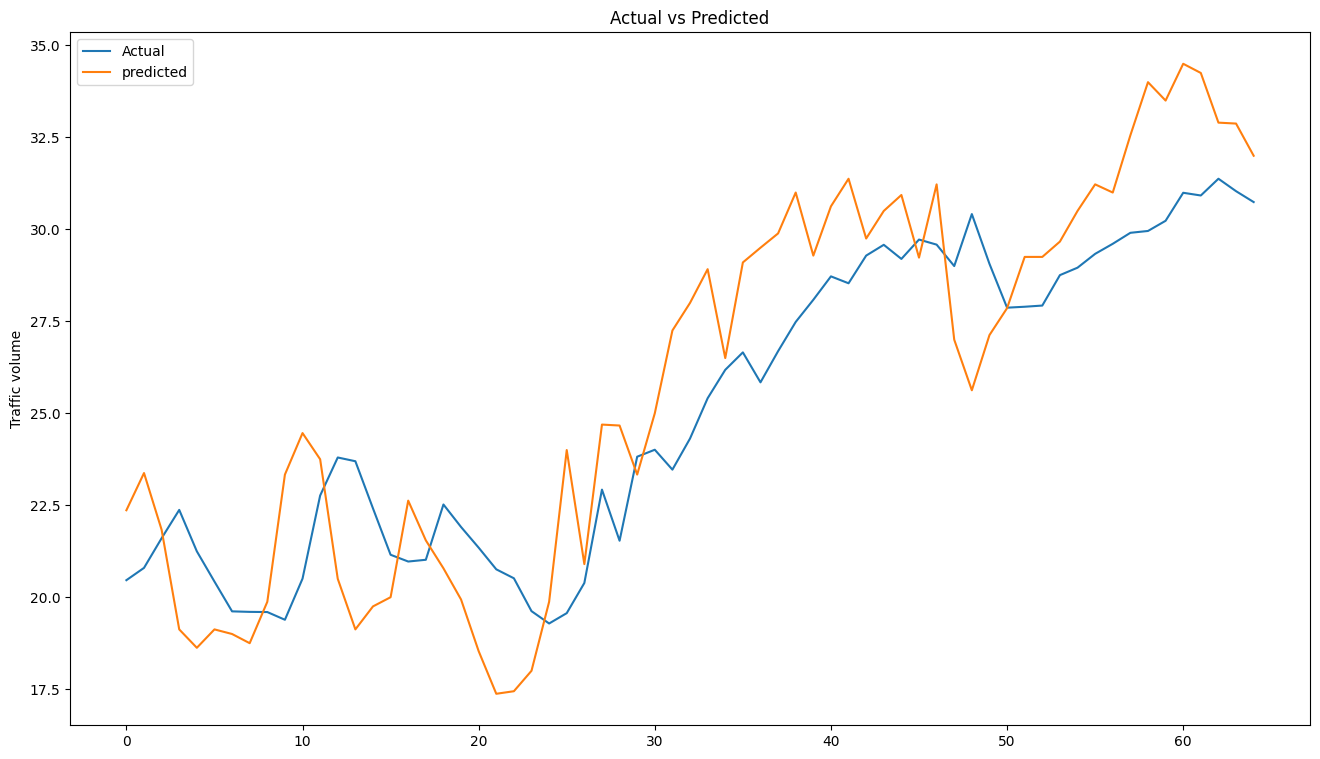

In [20]:
# plot predicted results against actual data
plt.figure(figsize=(16,9))
plt.plot( list(pred_inversed[:,0]))
plt.plot( list(np.array(test_data[['meantemp']][49:])))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()